# End Pointing of Speech signal

* Based on [Paper by Rabiner and Sambur](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6778857)

86766.54
64158.0
64158.0
/home/agrim/Processed_Data/0/15.wav Indices 6157:12382
/home/agrim/Processed_Data/0/16.wav Indices 14378:69596
/home/agrim/Processed_Data/1/15.wav Indices 70726:75247
/home/agrim/Processed_Data/1/16.wav Indices 80633:116677
/home/agrim/Processed_Data/2/15.wav Indices 120285:137640
/home/agrim/Processed_Data/2/16.wav Indices 140364:173830
/home/agrim/Processed_Data/3/15.wav Indices 176685:192224


IndexError: list index out of range

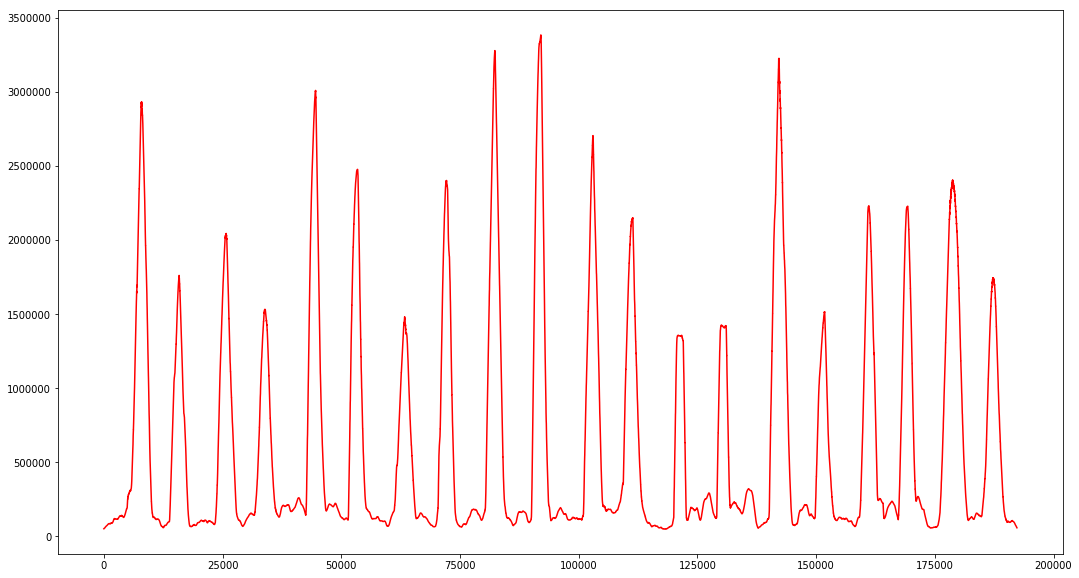

In [59]:
%matplotlib inline
from scipy import signal
from scipy.io.wavfile import write,read
import matplotlib.pyplot as plt
import math
import numpy as np
import IPython
from numpy import convolve
from scipy.signal import hamming
from scipy.ndimage.interpolation import shift
from scipy.linalg import toeplitz,inv
from scipy.fftpack import fft,fftshift,ifft

# Returns ndarray corresponding to voiced part in filename wav file
def endpointer(filename,Fs,glob_count=1):
    Ts=1/Fs
    read_wav = read(filename+'.wav')
    inp=np.array(read_wav[1],dtype='float64')
    plt.rcParams["figure.figsize"] = (18,10)
    #plt.title("Raw Input")
    #plt.plot(inp,'blue')
    
    #------------------------------------------------------------------------------
    #Compute Avg magnitude (Short Time), with window size N/20 (0-9 spoken twice)
    W=1000
    
    pad_zeros=np.zeros(W)
    zp_inp_t=np.append(pad_zeros,inp)
    zp_inp=np.append(zp_inp_t,pad_zeros)
    st_energy=[np.sum(abs(zp_inp[i-W:i+W])) for i in range(W,zp_inp.size-W)]
    plt.plot(st_energy,'red')

    #Assuming first 100ms to be noise
    num_samp_in_sil=int(0.01*Fs)
    sil_inp=st_energy[0:num_samp_in_sil]
    
    #Compute Peak Energy Imax and Silence Energy Imin
    Imx=np.amax(st_energy)
    Imn=np.amax(sil_inp)
    #print(Imn)
    #Compute ITL and ITU
    I1=0.01*(Imx-Imn)+Imn
    I2=1.2*Imn
    print(I1)
    print(I2)
    ITL=min(I1,I2)
    #ITL=12250
    print(ITL)
    ITU=10*ITL
    
    #Search Fwd
    i=0
    while(True):
        #print(i)
        if(i==0):
            start_index=num_samp_in_sil+1
        zero_st,zero_fi=search(st_energy,start_index,ITU,ITL)
        #print (zero_fi)
        if(zero_st==-1):
            start_index=zero_fi
            continue
        filename="/home/agrim/Processed_Data/"+str(int(i/2))+"/"+str(glob_count+(i%2))+".wav"
        print (filename+" Indices "+str(zero_st)+":"+str((zero_fi)))
        end_point_sig=inp[zero_st:zero_fi]
        
        write(filename, 8000, np.array(end_point_sig).astype(np.dtype('i2')))
        start_index=zero_fi
        i=i+1
        if(i==20):
            break
        #plt.plot(inp[zero_st:zero_fi])
        
endpointer('./Raw_Data/Digits_male_8Khz/zero_to_nine_Hitesh2',8000,15)


In [39]:
def search(st_avg,start_index,ITU,ITL):
    N1=0
    N2=0
    m=start_index    
    #Fwd Search
    while(True):
        flag=0
        #print(st_avg[m]-ITL)
        if(st_avg[m] >= ITL):
            i=m
            contender=m
            while(True):
                if(st_avg[i]<ITL):
                    flag=1
                    break
                if(st_avg[i]>=ITU):
                    contender=i
                    flag=2
                    break
                else: 
                    #print("Stuck here")
                    i=i+1
            
            if(flag==2):              
                N1=contender
                break
        if(flag==1):
            m=i+1
        if(flag==0):
            m=m+1

                
    #Bkwd Search
    m=N1+1
    while(True):
        flag=0
        if(st_avg[m] <= ITU):
            i=m
            contender=m
            while(True):
                if(st_avg[i]>ITU):
                    flag=1
                    break
                if(st_avg[i]<=ITL):
                    contender=i
                    flag=2
                    break
                else: 
                    i=i+1
            
            if(flag==2):
                N2=contender
                break
                
        if(flag==1):
            m=i+1
        if(flag==0):
            m=m+1
    
    # Do not consider noise (Utterance of less than 1600 samples => 0.2 sec)
    if((N2-N1)<1600):
        return -1,N2+1
    return N1,N2
            
    
 